<a href="https://colab.research.google.com/github/Patrick5455/Change-Point-Analysis-of-Covid19-Bayesian-Inference-SIR-SEIR-Modelling/blob/master/dependencies/covid19_inference-master/scripts/interactive/example_one_bundesland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/model_cleanup/scripts/interactive/example_one_bundesland.ipynb)

In [67]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /tmp/pip-req-build-0hr7ge_s
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-0hr7ge_s
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=103637 sha256=319beec7d52528468b42d79cd9f2e573188843de35bf153d84a009b6fe3eea9b
  Stored in directory: /tmp/pip-ephem-wheel-cache-zqzf37m0/wheels/da/f1/e7/da56ba4fe019b70927b4bb10088f02f672b31b69fd54a6e613
Successfully built covid19-inference




1.   List item
2.   List item



# Bayesian Inference of Ghana Covid 19 Data
Non-hierarchical model using jhu data.

Runtime ~ 15 min

The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.


In [114]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm
import pickle

In [69]:
# Now to the fun stuff, we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19


## Data retrieval 

> Task a -c

- Download the COVID19 case data for your assigned country

- Pre-process the downloaded data such that the starting date of the data is when the number of covid19 cases in your country reaches 100 and dominated by a community transmission.

- It is unlikely but, if there are dates that have NaN values, perform linear regression to fill these missing values. Make sure the final data has a continuous date - ensure no date is missing. Zero number of cases for a given date is ok.



> Use John Hopkins Database

In [70]:
jhu = cov19.data_retrieval.JHU()  # It is important to download the dataset!
jhu.download_all_available_data()
# One could also parse True to the constructor of the class to force an auto download

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


Get total confirmed case for Ghana

In [71]:
bd = datetime.datetime(2020, 3, 14)  # For the date filter
ed = datetime.datetime.now() 

In [72]:
#cummulative record
ghana_cumm_record = jhu.get_total_confirmed_deaths_recovered(country='Ghana', begin_date= bd, end_date=ed)

In [73]:
ghana_cumm_record

,confirmed,deaths,recovered
date,,,
2020-03-14,3,0,0
2020-03-15,6,0,0
2020-03-16,6,0,0
2020-03-17,7,0,0
2020-03-18,7,0,0
...,...,...,...
2020-08-02,37014,182,33365
2020-08-03,37812,191,34313
2020-08-04,37812,191,34313


In [126]:
#check for NaN values
ghana_cumm_record.index.isna().any()

False

In [74]:
# new cases
ghana_new_record = jhu.get_new(country = "Ghana", data_begin= bd, data_end=ed)
ghana_new_record

date
2020-03-14       3
2020-03-15       3
2020-03-16       0
2020-03-17       1
2020-03-18       0
              ... 
2020-08-02       0
2020-08-03     798
2020-08-04       0
2020-08-05    1263
2020-08-06     567
Name: confirmed, Length: 146, dtype: int64

In [127]:
#check for NaN values
ghana_new_record.index.isnull().any()

False

> Get when the first 100 case was recorded

In [75]:
ghana_covid_100_date = ghana_cumm_record[ghana_cumm_record.confirmed >=100]['confirmed'].head(1).index[0]

In [76]:
ghana_covid_100_date

Timestamp('2020-03-26 00:00:00')

In [77]:
working_data = ghana_new_record.loc['2020-03-26':]

In [78]:
working_data.head(5)

date
2020-03-26    39
2020-03-27     5
2020-03-28     4
2020-03-29    11
2020-03-30     0
Name: confirmed, dtype: int64

# Preprocessing and Modelling 
> Task d - f
- Split the data into one part used for inference (training set), and an other used for to validate a forecast (validation set):
- - Training set includes all dates from the time the community transmission reaches 100 to July 25 2020.
- - Validation set includes dates from 25 July 2020 to one final date in the covid19 cases data.  
- Plot the training data together with the model that is sampled from the posterior of the SIR model. The posterior of the SIR model means distributions on the Lambda, Mu, and other parameters. A single model curve means a single sample from the posterior distribution.
- Use the validation data set to evaluate the forecasting power of the model you generated using the training set. If you are happy with your model, you can run it to make predictions until the 10th of August.


In [81]:
train_data = working_data.loc[:"2020-07-25"]
train_data

date
2020-03-26      39
2020-03-27       5
2020-03-28       4
2020-03-29      11
2020-03-30       0
              ... 
2020-07-21     559
2020-07-22     683
2020-07-23       0
2020-07-24    1385
2020-07-25     794
Name: confirmed, Length: 122, dtype: int64

In [83]:
validation_data = working_data["2020-07-25":]

### Model training and Plotting (before identifying changepoints from the model output)

> Prior parameters and Prior Changepoints

- pr_delay = 3

- population = 31072940

- Changepoints 

`date covid started in Ghana and dates of govt policies before the first 100 case was recorded.`

`I used these dates as prior becuase I believe there should be significant changepoints arounf these policy dates. But I will test my priors with the posteriors of my model. Note these dates are two days ahead the original dates to accomodate for the delay in effects of changepoints` 

> 1. 2020, 3, 16 - first covid case
2. 2020, 03, 17 - ban on major gatherings
3. 2020, 03, 19 - restriction on travel

In [129]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 7

In [130]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 16)
prior_date_strong_dist_begin = datetime.datetime(2020, 6, 17)
prior_date_contact_ban_begin = datetime.datetime(2020, 7, 19)

In [132]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]



Next, we create the model! There are default values for most of the function arguments,
but we will try to explicitly set all kwargs for the sake of this example.


In [133]:
params_model = dict(
    new_cases_obs=train_data[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population= 31072940,
)
# Median of the prior for the delay in case reporting, we assume 3 days
pr_delay = 3



The model is specified in a context. Each function in this context
has access to the model parameters set.


In [134]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  


## MCMC sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time.


In [ ]:
model1 = pm.sample(model=this_model, cores=2, tune=50, draws=150, init="advi+adapt_diag")

Only 150 samples in chain.
WARNING  [pymc3] Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 1,313.2:   1%|          | 1674/200000 [00:15<31:49, 103.84it/s]

Save Model

In [119]:
#To mount the Google Drive
from google.colab import drive
drive.mount('/content/gdrive')#To Save the trace results to a pickle file
pickle_out = open("model1.pickle","wb")
pickle.dump(model1, pickle_out)
pickle_out.close()
#When it saves, look in the navigation pane on your left, you will see the trace.pickle file there, download it to your hard drive and every time you run a google colab instance, you can upload it #To load the file from pickle
pickle_in = open("model1.pickle","rb")
model1= pickle.load(pickle_in)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



## Plotting
Plotting tools are rudimentary right now. But one can always write custom plotting function
by accessing the samples stored in the trace.

### Distributions


Possible varnames are :
['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'lambda_3_log_', 'transient_day_1', 'transient_day_2', 'transient_day_3', 'transient_len_1_log_', 'transient_len_2_log_', 'transient_len_3_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


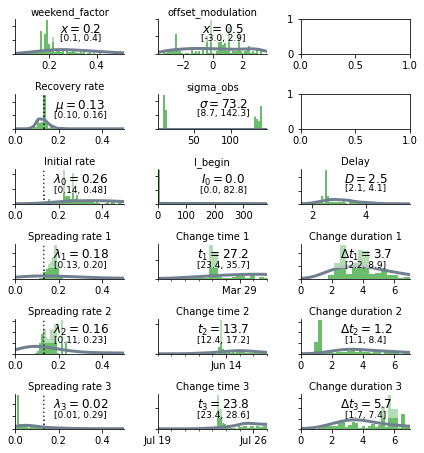

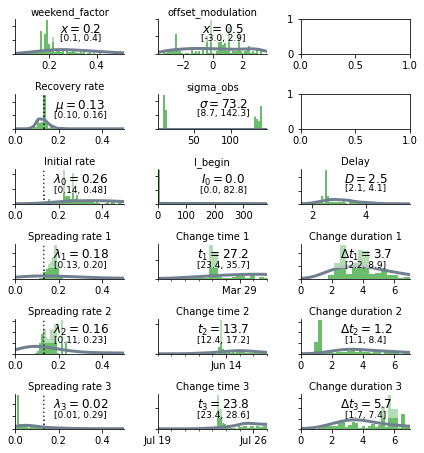

In [124]:
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4));
varnames = this_model.untransformed_freeRVs
print("Possible varnames are :")
print(varnames)
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, model1, key, ax=axes[i, 0]) #replcae trace with model1
for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, model1, key, ax=axes[i, 1])
for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(this_model, model1, key, ax=axes[i + 2, 2])
fig.tight_layout()
fig #To print in jupyter notebook


### Timeseries
timeseries overview, for now needs an offset variable to get cumulative cases


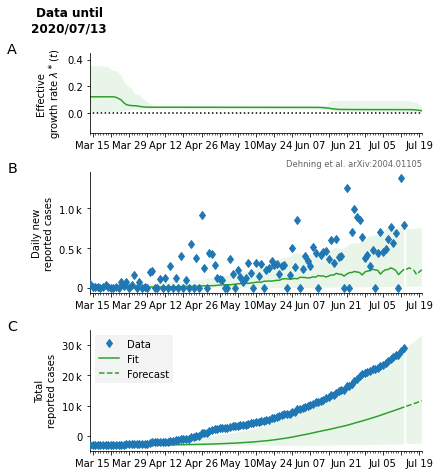

In [125]:
fig, axes = cov19.plot.timeseries_overview(this_model, model1, offset=-3000)

In [ ]:
# ### Changepoints

#  - Fisrst covid record
# >> Begin Date(bd) - March 14, 2020

# - prior data before mild social distancing began
# >> Ban major Gatherings — March 15, 2020 

# -  prior data before strong social distancing began
# >>  Travel Restrictions — March 17 2020

# - prior data before contact ban begin
# >> Partial Lockdown — March 30, 2020-Second Model ( Task 2 g to j) Dates.

# >>Mask Wearing Mandatory — June 15, 
# 2020

# >>Relaxing the Previous Rules — July 26,  2020
